In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import statsmodels.formula.api as smf

In [104]:
# Load datasets
africa_visa_openness_2019 = pd.read_csv("input/africa_visa_openness_2019.csv")
africa_visa_openness_2023 = pd.read_csv("input/africa_visa_openness_2023.csv")
passport_index_2019 = pd.read_csv("input/passport-index-2019.csv")
passport_index_2023 = pd.read_csv("input/passport-index-2023.csv")
henley_passport_index_2025 = pd.read_csv("input/henley_passport_index_2025.csv")
gdp_per_capita_2019_2023 = pd.read_csv("input/gdp_per_capita_2019_2023.csv")
country_region_income_group = pd.read_csv("input/country_region_income_group.csv")

In [105]:
# Rename columns
africa_visa_openness_2019 = africa_visa_openness_2019.rename(columns={
    "Country": "country",
    "ISO3": "iso3",
    "No visa required": "avoi_no_visa_2019",
    "Visa on arrival": "avoi_visa_on_arrival_2019",
    "Visa required": "avoi_visa_required_2019",
    "Score": "avoi_score_2019",
    "Rank": "avoi_rank_2019"
})

africa_visa_openness_2023 = africa_visa_openness_2023.rename(columns={
    "Country": "country",
    "ISO3": "iso3",
    "No visa required": "avoi_no_visa_2023",
    "Visa on arrival": "avoi_visa_on_arrival_2023",
    "Visa required": "avoi_visa_required_2023",
    "Score": "avoi_score_2023",
    "Rank": "avoi_rank_2023"
})

passport_index_2019 = passport_index_2019.rename(columns={
    "Passport": "origin_iso3",
    "Destination": "destination_iso3",
    "Code": "code",
})

passport_index_2023 = passport_index_2023.rename(columns={
    "Passport": "origin_iso3",
    "Destination": "destination_iso3",
    "Requirement": "requirement",
})

henley_passport_index_2025 = henley_passport_index_2025.rename(columns={
    "Passport": "country",
    "ISO3": "iso3",
    "Visa-free score": "henley_score_2025",
    "Rank": "henley_rank_2025"
})

gdp_per_capita_2019_2023 = gdp_per_capita_2019_2023.rename(columns={
    "Country Code": "iso3",
    "2019": "gdp_ppc_2019",
    "2020": "gdp_ppc_2020",
    "2021": "gdp_ppc_2021",
    "2022": "gdp_ppc_2022",
    "2023": "gdp_ppc_2023"
})

country_region_income_group = country_region_income_group.rename(columns={
    "Country Code": "iso3",
    "Region": "region",
    "IncomeGroup": "income_group"
})

In [106]:
# Recode passport index
code_to_requirement_2019 = {
    3: 'visa free',
    2: 'visa on arrival',
    1: 'e-visa',
    0: 'visa required',
   -1: 'self-passport'
}

requirement_to_code_2023 = {
    'visa free': 3,
    'visa on arrival': 2,
    'e-visa': 1,
    'visa required': 0,
    'covid ban': -2,
    'no admission': -3,
    'Hayya Entry Permit': -4,
    '-1': -1
}

passport_index_2019["requirement"] = passport_index_2019["code"].map(code_to_requirement_2019).astype("category")
passport_index_2023["code"] = passport_index_2023["requirement"].map(requirement_to_code_2023).astype("Int64")

In [107]:
# Build graphs for passport index
graph_2019 = nx.DiGraph()
graph_2023 = nx.DiGraph()

# Only include edges where the code is greater than zero
for _, row in passport_index_2019[passport_index_2019["code"] >= 2].iterrows():
    origin = row["origin_iso3"]
    destination = row["destination_iso3"]
    graph_2019.add_edge(origin, destination)

for _, row in passport_index_2023[passport_index_2023["code"] >= 2].iterrows():
    origin = row["origin_iso3"]
    destination = row["destination_iso3"]
    graph_2023.add_edge(origin, destination)

# Compute centrality measures
katz_2019 = nx.katz_centrality_numpy(graph_2019, alpha=0.005, beta=1.0)
pagerank_2019 = nx.pagerank(graph_2019)
betweenness_2019 = nx.betweenness_centrality(graph_2019)
closeness_2019 = nx.closeness_centrality(graph_2019)

katz_2023 = nx.katz_centrality_numpy(graph_2023, alpha=0.005, beta=1.0)
pagerank_2023 = nx.pagerank(graph_2023)
betweenness_2023 = nx.betweenness_centrality(graph_2023)
closeness_2023 = nx.closeness_centrality(graph_2023)

nodes_2019 = list(graph_2019.nodes())
nodes_2023 = list(graph_2023.nodes())

centrality_2019 = pd.DataFrame({
    "iso3": nodes_2019,
    "passport_index_katz_2019": [katz_2019.get(n, None) for n in nodes_2019],
    "passport_index_pagerank_2019": [pagerank_2019.get(n, None) for n in nodes_2019],
    "passport_index_betweenness_2019": [betweenness_2019.get(n, None) for n in nodes_2019],
    "passport_index_closeness_2019": [closeness_2019.get(n, None) for n in nodes_2019],
})

centrality_2023 = pd.DataFrame({
    "iso3": nodes_2023,
    "passport_index_katz_2023": [katz_2023.get(n, None) for n in nodes_2023],
    "passport_index_pagerank_2023": [pagerank_2023.get(n, None) for n in nodes_2023],
    "passport_index_betweenness_2023": [betweenness_2023.get(n, None) for n in nodes_2023],
    "passport_index_closeness_2023": [closeness_2023.get(n, None) for n in nodes_2023]
})

In [108]:
# Merge datasets
merged = (africa_visa_openness_2019
    .merge(africa_visa_openness_2023, on="iso3", how="outer", suffixes=("", "_dup1"))
    .merge(henley_passport_index_2025, on="iso3", how="outer", suffixes=("", "_dup2"))
    .merge(centrality_2019, on="iso3", how="outer")
    .merge(centrality_2023, on="iso3", how="outer")
    .merge(gdp_per_capita_2019_2023, on="iso3", how="outer")
    .merge(country_region_income_group, on="iso3", how="left")
)

In [109]:
# Handle duplicate country names
merged["country"] = (
    merged["country"]
    .combine_first(merged.get("country_dup1"))
    .combine_first(merged.get("country_dup2"))
)

In [110]:
# Drop duplicate columns
merged = merged.drop(columns=[col for col in merged.columns if col.startswith("country_dup")])

In [111]:
# Drop duplicate rows
merged = merged.drop_duplicates()

In [112]:
# Remove rows with no country, iso3, or region
merged_cleaned = merged.dropna(subset=["country", "iso3", "region"])

In [113]:
# Remove rows with no GDP per capita
merged_cleaned = merged_cleaned.dropna(subset=["gdp_ppc_2019", "gdp_ppc_2020", "gdp_ppc_2021", "gdp_ppc_2022", "gdp_ppc_2023"])

In [114]:
# Remove GDP columns other than 2019 and 2023
merged_cleaned = merged_cleaned.drop(columns=["gdp_ppc_2020", "gdp_ppc_2021", "gdp_ppc_2022"])

In [115]:
# Add log GDP per capita
merged_cleaned["log_gdp_ppc_2019"] = np.log(merged_cleaned["gdp_ppc_2019"])
merged_cleaned["log_gdp_ppc_2023"] = np.log(merged_cleaned["gdp_ppc_2023"])

In [116]:
# Adding differences between 2023 and 2019
merged_cleaned["avoi_no_visa_change"] = merged_cleaned["avoi_no_visa_2023"] - merged_cleaned["avoi_no_visa_2019"]
merged_cleaned["avoi_visa_on_arrival_change"] = merged_cleaned["avoi_visa_on_arrival_2023"] - merged_cleaned["avoi_visa_on_arrival_2019"]
merged_cleaned["avoi_visa_required_change"] = merged_cleaned["avoi_visa_required_2023"] - merged_cleaned["avoi_visa_required_2019"]
merged_cleaned["avoi_score_change"] = merged_cleaned["avoi_score_2023"] - merged_cleaned["avoi_score_2019"]
merged_cleaned["avoi_rank_change"] = merged_cleaned["avoi_rank_2023"] - merged_cleaned["avoi_rank_2019"]
merged_cleaned["gdp_ppc_change"] = merged_cleaned["gdp_ppc_2023"] - merged_cleaned["gdp_ppc_2019"]
merged_cleaned["log_gdp_ppc_change"] = merged_cleaned["log_gdp_ppc_2023"] - merged_cleaned["log_gdp_ppc_2019"]

merged_cleaned["passport_index_katz_change"] = merged_cleaned["passport_index_katz_2023"] - merged_cleaned["passport_index_katz_2019"]
merged_cleaned["passport_index_pagerank_change"] = merged_cleaned["passport_index_pagerank_2023"] - merged_cleaned["passport_index_pagerank_2019"]
merged_cleaned["passport_index_betweenness_change"] = merged_cleaned["passport_index_betweenness_2023"] - merged_cleaned["passport_index_betweenness_2019"]
merged_cleaned["passport_index_closeness_change"] = merged_cleaned["passport_index_closeness_2023"] - merged_cleaned["passport_index_closeness_2019"]


In [117]:
# Set index as country code
merged_cleaned = merged_cleaned.set_index("iso3")

In [118]:
# Attach attributes to nodes
for iso3 in graph_2023.nodes():
    if iso3 in merged_cleaned.index:
        for col in merged_cleaned.columns:
            graph_2023.nodes[iso3][col] = merged_cleaned.loc[iso3, col]
            
for iso3 in graph_2019.nodes():
    if iso3 in merged_cleaned.index:
        for col in merged_cleaned.columns:
            graph_2019.nodes[iso3][col] = merged_cleaned.loc[iso3, col]

In [119]:
merged_cleaned.head()

,country,avoi_no_visa_2019,avoi_visa_on_arrival_2019,avoi_visa_required_2019,avoi_score_2019,avoi_rank_2019,avoi_no_visa_2023,avoi_visa_on_arrival_2023,avoi_visa_required_2023,avoi_score_2023,...,avoi_visa_on_arrival_change,avoi_visa_required_change,avoi_score_change,avoi_rank_change,gdp_ppc_change,log_gdp_ppc_change,passport_index_katz_change,passport_index_pagerank_change,passport_index_betweenness_change,passport_index_closeness_change
iso3,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-934.820750,-0.384710,0.022091,0.000000,0.000000,0.000000
AGO,Angola,10.0,7.0,36.0,0.294,34.0,10.0,0.0,43.0,0.189,...,-7.0,7.0,-0.105,7.0,-1029.649509,-0.132887,-0.000965,-0.002353,-0.000224,-0.248015
ALB,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2910.048820,0.176602,-0.005553,-0.002009,-0.000438,-0.291950
AND,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1415.396600,0.022143,0.000927,-0.002041,0.000555,-0.274880
ARE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-310.304840,-0.004515,-0.000076,-0.001230,-0.000460,-0.197613


In [120]:
merged_cleaned.describe()

,avoi_no_visa_2019,avoi_visa_on_arrival_2019,avoi_visa_required_2019,avoi_score_2019,avoi_rank_2019,avoi_no_visa_2023,avoi_visa_on_arrival_2023,avoi_visa_required_2023,avoi_score_2023,avoi_rank_2023,...,avoi_visa_on_arrival_change,avoi_visa_required_change,avoi_score_change,avoi_rank_change,gdp_ppc_change,log_gdp_ppc_change,passport_index_katz_change,passport_index_pagerank_change,passport_index_betweenness_change,passport_index_closeness_change
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,13.500000,14.403846,24.961538,0.474712,26.326923,15.192308,14.211538,23.596154,0.501173,26.307692,...,-0.192308,-1.365385,0.026462,-0.019231,893.365395,0.030854,-0.000294,0.000076,0.001719,-0.326811
std,10.861878,18.870310,19.184309,0.304847,15.415451,13.244368,18.693961,18.955324,0.308059,15.549464,...,12.541755,11.575886,0.178786,8.779411,4092.963250,0.133710,0.019725,0.006441,0.012756,0.275224
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.019000,1.000000,...,-36.000000,-47.000000,-0.476000,-34.000000,-28587.544500,-0.384710,-0.044973,-0.010307,-0.017041,-1.000000
25%,6.000000,0.000000,1.000000,0.256250,13.750000,6.750000,0.000000,1.000000,0.251750,13.750000,...,-0.250000,-1.000000,-0.001000,-0.250000,-91.698706,-0.009871,-0.010176,-0.002781,-0.001206,-0.592784
50%,14.000000,2.000000,31.500000,0.402000,26.500000,14.000000,2.000000,29.500000,0.422500,26.500000,...,0.000000,0.000000,0.000000,1.000000,349.553402,0.032311,0.000278,-0.002050,-0.000458,-0.277754
75%,17.000000,32.500000,39.250000,0.805750,39.250000,19.000000,26.000000,39.250000,0.802750,39.250000,...,0.000000,0.250000,0.019000,3.000000,1528.000647,0.078930,0.013360,0.001808,0.002016,-0.122201
max,53.000000,53.000000,53.000000,1.000000,54.000000,53.000000,53.000000,52.000000,1.000000,54.000000,...,47.000000,32.000000,0.710000,25.000000,35912.738800,1.302796,0.084640,0.024264,0.110330,0.461591


In [121]:
# Create a subset for each of these regions 'Sub-Saharan Africa' 'Middle East & North Africa'
merged_cleaned_sub_saharan = merged_cleaned[merged_cleaned["region"] == "Sub-Saharan Africa"]
merged_cleaned_north_africa = merged_cleaned[merged_cleaned["region"] == "Middle East & North Africa"]

In [122]:
list(merged_cleaned.columns)

['country',
 'avoi_no_visa_2019',
 'avoi_visa_on_arrival_2019',
 'avoi_visa_required_2019',
 'avoi_score_2019',
 'avoi_rank_2019',
 'avoi_no_visa_2023',
 'avoi_visa_on_arrival_2023',
 'avoi_visa_required_2023',
 'avoi_score_2023',
 'avoi_rank_2023',
 'henley_rank_2025',
 'henley_score_2025',
 'passport_index_katz_2019',
 'passport_index_pagerank_2019',
 'passport_index_betweenness_2019',
 'passport_index_closeness_2019',
 'passport_index_katz_2023',
 'passport_index_pagerank_2023',
 'passport_index_betweenness_2023',
 'passport_index_closeness_2023',
 'gdp_ppc_2019',
 'gdp_ppc_2023',
 'region',
 'income_group',
 'log_gdp_ppc_2019',
 'log_gdp_ppc_2023',
 'avoi_no_visa_change',
 'avoi_visa_on_arrival_change',
 'avoi_visa_required_change',
 'avoi_score_change',
 'avoi_rank_change',
 'gdp_ppc_change',
 'log_gdp_ppc_change',
 'passport_index_katz_change',
 'passport_index_pagerank_change',
 'passport_index_betweenness_change',
 'passport_index_closeness_change']

In [123]:
# regress log_gdp_ppc_2023 on avoi_score_2023 
smf.ols(formula="log_gdp_ppc_2023 ~ avoi_score_2023", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.135
Date:                Wed, 26 Mar 2025   Prob (F-statistic):              0.292
Time:                        13:43:37   Log-Likelihood:                -65.658
No. Observations:                  52   AIC:                             135.3
Df Residuals:                      50   BIC:                             139.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.6449      0.233     37.162      0.000       8.178       9.112
avoi_score_2023    -0.4223      0.396     -1.065      0.292      -1.219       0.374
==============================================================================
Omnibus:                        1.134   Durbin-Watson:                   2.447
Prob(Omnibus):                  0.567   Jarque-Bera (JB):                1.156
Skew:                           0.259   Prob(JB):                        0.561
Kurtosis:                       2.485   Cond. No.                         4.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# regress log_gdp_ppc_2023 on avoi_score_2023 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ avoi_score_2023 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     46.95
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           7.57e-16
Time:                        13:43:37   Log-Likelihood:                -24.417
No. Observations:                  52   AIC:                             58.83
Df Residuals:                      47   BIC:                             68.59
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.3344      0.452     22.840      0.000       9.424      11.245
income_group[T.Low income]             -2.7231      0.426     -6.388      0.000      -3.581      -1.866
income_group[T.Lower middle income]    -1.6535      0.427     -3.869      0.000      -2.513      -0.794
income_group[T.Upper middle income]    -0.6543      0.453     -1.445      0.155      -1.565       0.256
avoi_score_2023                        -0.0433      0.198     -0.219      0.828      -0.441       0.354
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.195
Skew:                           0.144   Prob(JB):                        0.907
Kurtosis:                       2.917   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
# regress log_gdp_ppc_2023 on avoi_score_2023 and income_group for only sub-Saharan Africa
smf.ols(formula="log_gdp_ppc_2023 ~ avoi_score_2023 + income_group", data=merged_cleaned_sub_saharan).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     51.14
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.09e-15
Time:                        13:43:37   Log-Likelihood:                -16.195
No. Observations:                  46   AIC:                             42.39
Df Residuals:                      41   BIC:                             51.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.1766      0.411     24.761      0.000       9.347      11.007
income_group[T.Low income]             -2.6528      0.383     -6.927      0.000      -3.426      -1.879
income_group[T.Lower middle income]    -1.7032      0.384     -4.430      0.000      -2.480      -0.927
income_group[T.Upper middle income]    -0.5090      0.410     -1.241      0.222      -1.338       0.320
avoi_score_2023                         0.1145      0.190      0.603      0.550      -0.269       0.498
==============================================================================
Omnibus:                        1.005   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.605   Jarque-Bera (JB):                1.058
Skew:                          -0.301   Prob(JB):                        0.589
Kurtosis:                       2.564   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
# regress log_gdp_ppc_2023 on avoi_score_2023 and income_group for only North Africa
# This may be because of Egypt's high GDP per capita and low visa openness
smf.ols(formula="log_gdp_ppc_2023 ~ avoi_score_2023 + income_group ", data=merged_cleaned_north_africa).fit().summary()

/Users/mtwesley/.pyenv/versions/anaconda3-2023.09-0/envs/cs7280/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     2.079
Date:                Wed, 26 Mar 2025   Prob (F-statistic):              0.271
Time:                        13:43:37   Log-Likelihood:                0.80869
No. Observations:                   6   AIC:                             4.383
Df Residuals:                       3   BIC:                             3.758
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.3939      0.115     55.453      0.000       6.027       6.761
income_group[T.Lower middle income]     3.1967      0.169     18.888      0.000       2.658       3.735
income_group[T.Upper middle income]     3.1972      0.155     20.629      0.000       2.704       3.690
avoi_score_2023                        -0.9399      0.540     -1.740      0.180      -2.659       0.779
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.067
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.555
Skew:                          -0.456   Prob(JB):                        0.758
Kurtosis:                       1.822   Cond. No.                     1.93e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.66e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [127]:
# regress log_gdp_ppc_2023 on henley_score_2025
smf.ols(formula="log_gdp_ppc_2023 ~ henley_score_2025", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     253.5
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.54e-36
Time:                        13:43:37   Log-Likelihood:                -209.01
No. Observations:                 184   AIC:                             422.0
Df Residuals:                     182   BIC:                             428.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.7489      0.128     60.461      0.000       7.496       8.002
henley_score_2025     0.0166      0.001     15.922      0.000       0.015       0.019
==============================================================================
Omnibus:                        0.417   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.812   Jarque-Bera (JB):                0.236
Skew:                          -0.079   Prob(JB):                        0.889
Kurtosis:                       3.074   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
# regress log_gdp_ppc_2023 on henley_score_2025 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ henley_score_2025 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     314.0
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           9.71e-80
Time:                        13:43:37   Log-Likelihood:                -97.769
No. Observations:                 184   AIC:                             205.5
Df Residuals:                     179   BIC:                             221.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.5477      0.176     60.100      0.000      10.201      10.894
income_group[T.Low income]             -3.0459      0.154    -19.746      0.000      -3.350      -2.742
income_group[T.Lower middle income]    -1.9670      0.128    -15.406      0.000      -2.219      -1.715
income_group[T.Upper middle income]    -0.9379      0.099     -9.480      0.000      -1.133      -0.743
henley_score_2025                       0.0016      0.001      1.572      0.118      -0.000       0.004
==============================================================================
Omnibus:                        3.383   Durbin-Watson:                   2.327
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                3.057
Skew:                          -0.220   Prob(JB):                        0.217
Kurtosis:                       3.453   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
# regress log_gdp_ppc_2023 on henley_score_2025 and region
smf.ols(formula="log_gdp_ppc_2023 ~ henley_score_2025 + region", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     64.37
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           3.02e-45
Time:                        13:43:37   Log-Likelihood:                -172.46
No. Observations:                 184   AIC:                             360.9
Df Residuals:                     176   BIC:                             386.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                8.0011      0.181     44.090      0.000       7.643       8.359
region[T.Europe & Central Asia]          0.4435      0.152      2.923      0.004       0.144       0.743
region[T.Latin America & Caribbean]      0.0009      0.163      0.006      0.995      -0.320       0.322
region[T.Middle East & North Africa]     0.9098      0.193      4.723      0.000       0.530       1.290
region[T.North America]                  0.5979      0.468      1.277      0.203      -0.326       1.522
region[T.South Asia]                     0.2747      0.278      0.987      0.325      -0.275       0.824
region[T.Sub-Saharan Africa]            -0.5627      0.161     -3.497      0.001      -0.880      -0.245
henley_score_2025                        0.0136      0.001     11.297      0.000       0.011       0.016
==============================================================================
Omnibus:                        1.170   Durbin-Watson:                   2.420
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                0.821
Skew:                          -0.027   Prob(JB):                        0.663
Kurtosis:                       3.323   Cond. No.                     1.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [130]:
# regress log_gdp_ppc_2023 on passport_index_katz_2023
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_katz_2023", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     23.34
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.88e-06
Time:                        13:43:37   Log-Likelihood:                -278.18
No. Observations:                 184   AIC:                             560.4
Df Residuals:                     182   BIC:                             566.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.9542      0.295     37.163      0.000      10.373      11.536
passport_index_katz_2023   -19.8964      4.119     -4.831      0.000     -28.023     -11.770
==============================================================================
Omnibus:                        5.129   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.290
Skew:                          -0.280   Prob(JB):                        0.117
Kurtosis:                       2.504   Cond. No.                         50.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
# regress log_gdp_ppc_2023 on passport_index_katz_2023 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_katz_2023 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     309.8
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.84e-79
Time:                        13:43:37   Log-Likelihood:                -98.874
No. Observations:                 184   AIC:                             207.7
Df Residuals:                     179   BIC:                             223.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.8710      0.121     89.664      0.000      10.632      11.110
income_group[T.Low income]             -3.2040      0.112    -28.734      0.000      -3.424      -2.984
income_group[T.Lower middle income]    -2.1130      0.083    -25.597      0.000      -2.276      -1.950
income_group[T.Upper middle income]    -1.0343      0.079    -13.090      0.000      -1.190      -0.878
passport_index_katz_2023               -0.9414      1.702     -0.553      0.581      -4.300       2.417
==============================================================================
Omnibus:                        3.307   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.955
Skew:                          -0.222   Prob(JB):                        0.228
Kurtosis:                       3.433   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
# regress log_gdp_ppc_2023 on passport_index_katz_2023 and income_group for only sub-Saharan Africa
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_katz_2023 + income_group", data=merged_cleaned_sub_saharan).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     50.64
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.47e-15
Time:                        13:43:37   Log-Likelihood:                -16.386
No. Observations:                  46   AIC:                             42.77
Df Residuals:                      41   BIC:                             51.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.3092      0.386     26.686      0.000       9.529      11.089
income_group[T.Low income]             -2.6938      0.381     -7.065      0.000      -3.464      -1.924
income_group[T.Lower middle income]    -1.7500      0.379     -4.623      0.000      -2.514      -0.986
income_group[T.Upper middle income]    -0.5765      0.396     -1.457      0.153      -1.375       0.222
passport_index_katz_2023               -0.3283      2.246     -0.146      0.885      -4.864       4.208
==============================================================================
Omnibus:                        0.889   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.940
Skew:                          -0.219   Prob(JB):                        0.625
Kurtosis:                       2.454   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
# regress log_gdp_ppc_2023 on passport_index_katz_2023 and region
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_katz_2023 + region", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     28.08
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           1.03e-25
Time:                        13:43:37   Log-Likelihood:                -220.28
No. Observations:                 184   AIC:                             456.6
Df Residuals:                     176   BIC:                             482.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               10.0771      0.275     36.582      0.000       9.533      10.621
region[T.Europe & Central Asia]          0.8541      0.191      4.464      0.000       0.477       1.232
region[T.Latin America & Caribbean]      0.1510      0.212      0.713      0.477      -0.267       0.569
region[T.Middle East & North Africa]     0.4532      0.244      1.856      0.065      -0.029       0.935
region[T.North America]                  1.3958      0.600      2.326      0.021       0.211       2.580
region[T.South Asia]                    -0.6092      0.346     -1.763      0.080      -1.291       0.073
region[T.Sub-Saharan Africa]            -1.2166      0.194     -6.277      0.000      -1.599      -0.834
passport_index_katz_2023                -6.9964      3.281     -2.132      0.034     -13.472      -0.520
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.024
Skew:                           0.028   Prob(JB):                        0.988
Kurtosis:                       3.007   Cond. No.                         59.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
# regress log_gdp_ppc_2023 on passport_index_katz_2023 and income_group and region
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_katz_2023 + income_group + region", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     137.2
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           8.94e-77
Time:                        13:43:37   Log-Likelihood:                -87.822
No. Observations:                 184   AIC:                             197.6
Df Residuals:                     173   BIC:                             233.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               10.6773      0.144     73.978      0.000      10.392      10.962
income_group[T.Low income]              -2.9657      0.142    -20.844      0.000      -3.247      -2.685
income_group[T.Lower middle income]     -1.9775      0.095    -20.866      0.000      -2.165      -1.790
income_group[T.Upper middle income]     -0.9340      0.080    -11.663      0.000      -1.092      -0.776
region[T.Europe & Central Asia]          0.2672      0.098      2.716      0.007       0.073       0.461
region[T.Latin America & Caribbean]     -0.0371      0.107     -0.347      0.729      -0.248       0.174
region[T.Middle East & North Africa]     0.2800      0.120      2.329      0.021       0.043       0.517
region[T.North America]                  0.4474      0.299      1.497      0.136      -0.143       1.037
region[T.South Asia]                     0.2555      0.174      1.470      0.143      -0.088       0.598
region[T.Sub-Saharan Africa]            -0.0759      0.111     -0.683      0.495      -0.295       0.143
passport_index_katz_2023                -0.7572      1.654     -0.458      0.648      -4.021       2.507
==============================================================================
Omnibus:                        0.728   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.402
Skew:                          -0.004   Prob(JB):                        0.818
Kurtosis:                       3.229   Cond. No.                         65.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
# regress log_gdp_ppc_2023 on passport_index_pagerank_2023
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_pagerank_2023", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     39.84
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.05e-09
Time:                        13:43:37   Log-Likelihood:                -271.07
No. Observations:                 184   AIC:                             546.1
Df Residuals:                     182   BIC:                             552.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        9.9148      0.094    105.418      0.000       9.729      10.100
passport_index_pagerank_2023   -62.3652      9.881     -6.312      0.000     -81.861     -42.869
==============================================================================
Omnibus:                        4.236   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                4.265
Skew:                          -0.342   Prob(JB):                        0.119
Kurtosis:                       2.703   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
# regress log_gdp_ppc_2023 on passport_index_pagerank_2023 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_pagerank_2023 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     311.0
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.08e-79
Time:                        13:43:37   Log-Likelihood:                -98.552
No. Observations:                 184   AIC:                             207.1
Df Residuals:                     179   BIC:                             223.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.8200      0.054    200.094      0.000      10.713      10.927
income_group[T.Low income]             -3.1819      0.114    -27.894      0.000      -3.407      -2.957
income_group[T.Lower middle income]    -2.0968      0.085    -24.727      0.000      -2.264      -1.930
income_group[T.Upper middle income]    -1.0284      0.079    -13.028      0.000      -1.184      -0.873
passport_index_pagerank_2023           -4.2123      4.357     -0.967      0.335     -12.810       4.385
==============================================================================
Omnibus:                        2.540   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.281   Jarque-Bera (JB):                2.135
Skew:                          -0.195   Prob(JB):                        0.344
Kurtosis:                       3.356   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
# regress log_gdp_ppc_2023 on passport_index_pagerank_2023 and income_group for only sub-Saharan Africa
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_pagerank_2023 + income_group", data=merged_cleaned_sub_saharan).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     50.61
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.50e-15
Time:                        13:43:37   Log-Likelihood:                -16.398
No. Observations:                  46   AIC:                             42.80
Df Residuals:                      41   BIC:                             51.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.2909      0.366     28.110      0.000       9.552      11.030
income_group[T.Low income]             -2.7061      0.381     -7.094      0.000      -3.476      -1.936
income_group[T.Lower middle income]    -1.7587      0.379     -4.640      0.000      -2.524      -0.993
income_group[T.Upper middle income]    -0.5792      0.396     -1.463      0.151      -1.379       0.220
passport_index_pagerank_2023            0.1892      5.882      0.032      0.974     -11.690      12.068
==============================================================================
Omnibus:                        0.893   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.955
Skew:                          -0.238   Prob(JB):                        0.620
Kurtosis:                       2.479   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
# regress log_gdp_ppc_2023 on passport_index_pagerank_2023 and region
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_pagerank_2023 + region", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     28.74
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           3.63e-26
Time:                        13:43:37   Log-Likelihood:                -219.16
No. Observations:                 184   AIC:                             454.3
Df Residuals:                     176   BIC:                             480.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                9.7354      0.160     60.979      0.000       9.420      10.050
region[T.Europe & Central Asia]          0.7896      0.194      4.068      0.000       0.406       1.173
region[T.Latin America & Caribbean]      0.1360      0.211      0.646      0.519      -0.279       0.552
region[T.Middle East & North Africa]     0.3868      0.244      1.585      0.115      -0.095       0.868
region[T.North America]                  1.3723      0.597      2.300      0.023       0.195       2.550
region[T.South Asia]                    -0.6042      0.343     -1.761      0.080      -1.281       0.073
region[T.Sub-Saharan Africa]            -1.2045      0.193     -6.251      0.000      -1.585      -0.824
passport_index_pagerank_2023           -21.9542      8.444     -2.600      0.010     -38.619      -5.290
==============================================================================
Omnibus:                        0.362   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.134
Skew:                           0.028   Prob(JB):                        0.935
Kurtosis:                       3.120   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
# regress log_gdp_ppc_2023 on passport_index_pagerank_2023 and income_group and region
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_pagerank_2023 + income_group + region", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     137.2
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           9.32e-77
Time:                        13:43:37   Log-Likelihood:                -87.866
No. Observations:                 184   AIC:                             197.7
Df Residuals:                     173   BIC:                             233.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               10.6336      0.092    115.076      0.000      10.451      10.816
income_group[T.Low income]              -2.9672      0.143    -20.770      0.000      -3.249      -2.685
income_group[T.Lower middle income]     -1.9768      0.096    -20.686      0.000      -2.165      -1.788
income_group[T.Upper middle income]     -0.9318      0.080    -11.649      0.000      -1.090      -0.774
region[T.Europe & Central Asia]          0.2653      0.100      2.661      0.009       0.069       0.462
region[T.Latin America & Caribbean]     -0.0363      0.107     -0.340      0.735      -0.247       0.175
region[T.Middle East & North Africa]     0.2755      0.121      2.280      0.024       0.037       0.514
region[T.North America]                  0.4506      0.299      1.508      0.133      -0.139       1.040
region[T.South Asia]                     0.2533      0.174      1.458      0.147      -0.090       0.596
region[T.Sub-Saharan Africa]            -0.0761      0.111     -0.685      0.494      -0.295       0.143
passport_index_pagerank_2023            -1.5271      4.287     -0.356      0.722      -9.989       6.935
==============================================================================
Omnibus:                        0.744   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.416
Skew:                          -0.005   Prob(JB):                        0.812
Kurtosis:                       3.233   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
# regress log_gdp_ppc_2023 on passport_index_betweenness_2023 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_betweenness_2023 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     310.2
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           2.55e-79
Time:                        13:43:37   Log-Likelihood:                -98.763
No. Observations:                 184   AIC:                             207.5
Df Residuals:                     179   BIC:                             223.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.8195      0.055    197.973      0.000      10.712      10.927
income_group[T.Low income]             -3.2254      0.106    -30.430      0.000      -3.435      -3.016
income_group[T.Lower middle income]    -2.1274      0.080    -26.470      0.000      -2.286      -1.969
income_group[T.Upper middle income]    -1.0327      0.079    -13.088      0.000      -1.188      -0.877
passport_index_betweenness_2023        -1.7171      2.375     -0.723      0.471      -6.404       2.969
==============================================================================
Omnibus:                        2.869   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.491
Skew:                          -0.202   Prob(JB):                        0.288
Kurtosis:                       3.401   Cond. No.                         83.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
# regress log_gdp_ppc_2023 on passport_index_closeness_2023 and income_group
smf.ols(formula="log_gdp_ppc_2023 ~ passport_index_closeness_2023 + income_group", data=merged_cleaned).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_gdp_ppc_2023   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     309.3
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           3.16e-79
Time:                        13:43:37   Log-Likelihood:                -98.983
No. Observations:                 184   AIC:                             208.0
Df Residuals:                     179   BIC:                             224.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.8226      0.066    164.245      0.000      10.693      10.953
income_group[T.Low income]             -3.2135      0.111    -29.053      0.000      -3.432      -2.995
income_group[T.Lower middle income]    -2.1196      0.081    -26.038      0.000      -2.280      -1.959
income_group[T.Upper middle income]    -1.0352      0.079    -13.025      0.000      -1.192      -0.878
passport_index_closeness_2023          -0.0345      0.113     -0.304      0.761      -0.258       0.189
==============================================================================
Omnibus:                        3.554   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.228
Skew:                          -0.231   Prob(JB):                        0.199
Kurtosis:                       3.456   Cond. No.                         4.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

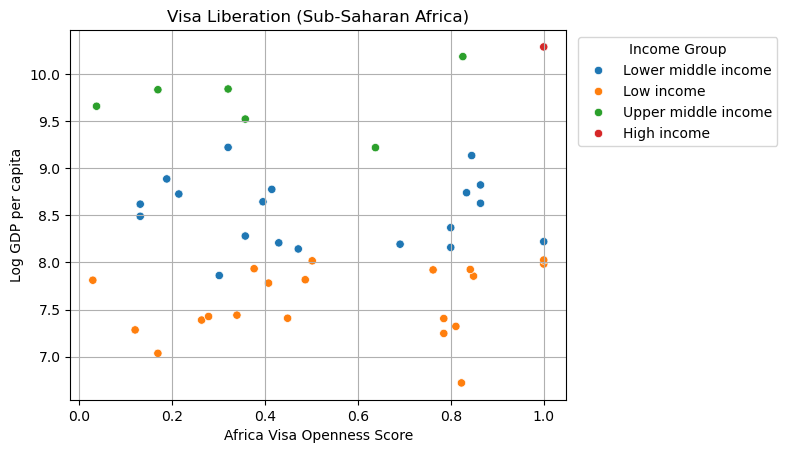

In [142]:
# Plot the relationship between log GDP per capita and visa openness score
plt.figure()
sns.scatterplot(
    data=merged_cleaned_sub_saharan,
    x="avoi_score_2023",
    y="log_gdp_ppc_2023",
    hue="income_group",
)
plt.title("Visa Liberation (Sub-Saharan Africa)")
plt.xlabel("Africa Visa Openness Score")
plt.ylabel("Log GDP per capita")
plt.legend(title="Income Group", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid()
plt.show()

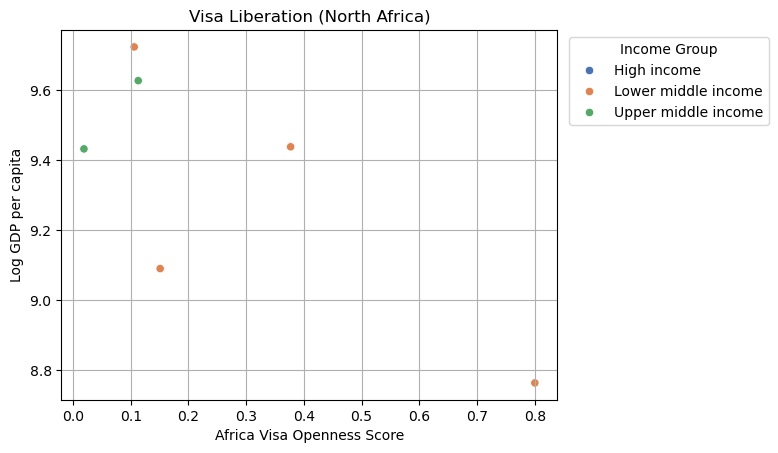

In [143]:
# Plot the relationship between log GDP per capita and visa openness score
plt.figure()
sns.scatterplot(
    data=merged_cleaned_north_africa,
    x="avoi_score_2023",
    y="log_gdp_ppc_2023",
    hue="income_group",
    palette="deep",
)
plt.title("Visa Liberation (North Africa)")
plt.xlabel("Africa Visa Openness Score")
plt.ylabel("Log GDP per capita")
plt.legend(title="Income Group", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid()
plt.show()

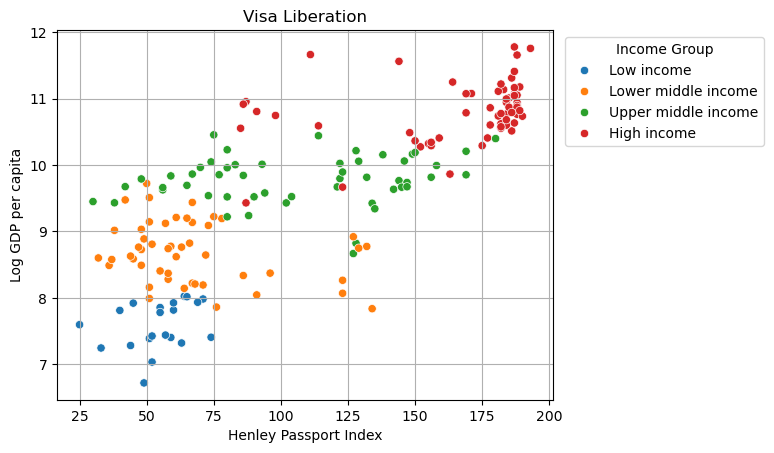

In [144]:
# Plot the relationship between log GDP per capita and visa openness score
plt.figure()
sns.scatterplot(
    data=merged_cleaned,
    x="henley_score_2025",
    y="log_gdp_ppc_2023",
    hue="income_group",
)
plt.title("Visa Liberation")
plt.xlabel("Henley Passport Index")
plt.ylabel("Log GDP per capita")
plt.legend(title="Income Group", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid()
plt.show()

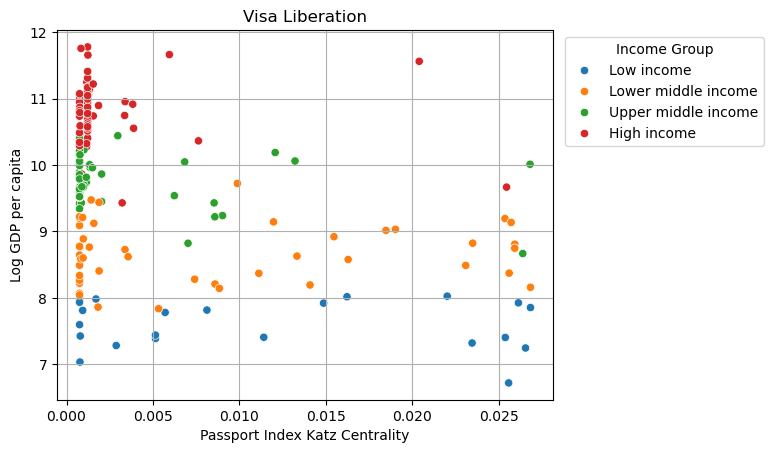

In [145]:
# Plot the relationship between log GDP per capita and visa openness score
plt.figure()
sns.scatterplot(
    data=merged_cleaned,
    x="passport_index_pagerank_2023",
    y="log_gdp_ppc_2023",
    hue="income_group",
)
plt.title("Visa Liberation")
plt.xlabel("Passport Index Katz Centrality")
plt.ylabel("Log GDP per capita")
plt.legend(title="Income Group", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid()
plt.show()

In [166]:
# Graph for Sub-Saharan Africa
sub_saharan_nodes = [n for n, attr in graph_2023.nodes(data=True) if attr.get("region") == "Sub-Saharan Africa"]
sub_saharan_graph = graph_2023.subgraph(sub_saharan_nodes).to_undirected()

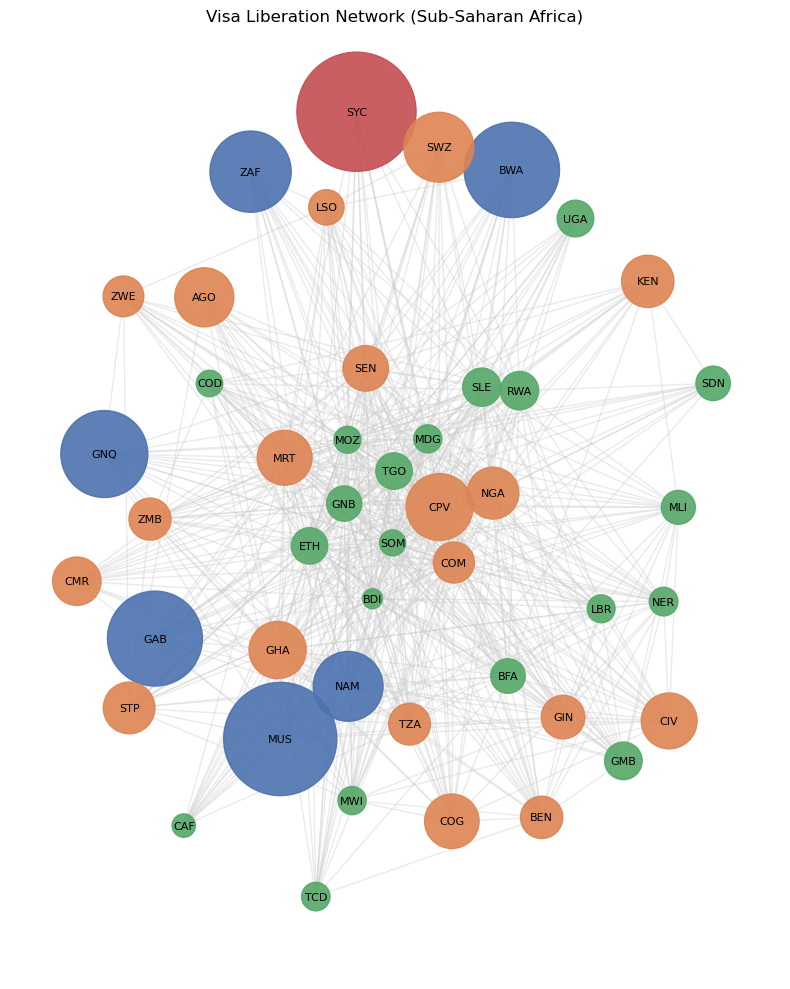

In [175]:
income_groups = list(set(nx.get_node_attributes(sub_saharan_graph, "income_group").values()))
income_color_map = dict(zip(income_groups, sns.color_palette("deep", len(income_groups))))

# Node color by income group
node_colors = [
    income_color_map.get(sub_saharan_graph.nodes[n].get("income_group"), "#ccc")
    for n in sub_saharan_graph.nodes
]

# Node sizes by log GDP per capita
node_sizes = [merged_cleaned.loc[n, "gdp_ppc_2023"] / 4 for n in sub_saharan_graph.nodes]

pos = nx.spring_layout(sub_saharan_graph)

plt.figure(figsize=(8, 10))
nx.draw_networkx_nodes(sub_saharan_graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(sub_saharan_graph, pos, edge_color="#ccc", alpha=0.4, width=1)
nx.draw_networkx_labels(sub_saharan_graph, pos, font_size=8)
plt.title("Visa Liberation Network (Sub-Saharan Africa)")
plt.axis("off")
plt.tight_layout()
plt.show()